<a href="https://colab.research.google.com/github/Kakumanu-Harshitha/Plant_Disease_Detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Model Description:

Plant Disease Detection Model is designed to help users quickly and accurately identify plant diseases by simply uploading a photo of the affected plant's leaf. With the power of computer vision and deep learning, the model analyzes the image and provides instant feedback on whether the plant is healthy or suffering from a disease, along with the name of the disease.

# 1. Install Requirements and Import Libraries

In [ ]:
!pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# 2.Import Dataset
As i am using a dataset from kaggle so i uploaded my kaggle API file to download required dataset

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kakumanuharshitha","key":"06de50b59fe4e1311ff0d781072953d4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

This is a plant disease detection dataset with 15 different classes(Diseases) of different crops.

Dataset Source: https://www.kaggle.com/datasets/emmarex/plantdisease

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

# 3. Split in to training and validation dataset
split data in ratio of 4:1 with an image size of (224,224) and label the data with "categorical" for classifying.

In [ ]:
train_dir="/content/PlantVillage"
IMG_SIZE=[224,224]
train_data, test_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                                validation_split=0.2,
                                                                                seed = 42,
                                                                                batch_size=32,
                                                                                subset="both")


Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Using 4127 files for validation.


In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

# 4. Build a model
Create Model: Let's fine tune a EfficientB0 model on imagenet weights as it is the best model till now for plant disease detection because it was trained on large data of imagenet with more quality images. The architecture is also very robust with many layers and nuerons....so that model can extract very precised features and classify the plant diseases.

As we are using pretrained model for fine tuning we must set down the real weights of model aprt from architecture.Remove the top layer(classification layer) to customize as per our requirement.

In [ ]:
from tensorflow.keras import layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(15)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 15)                  │          19,215 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 15)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**Compile** **Model**: Compile our model with Adam optimizer and categorical crossentropy as our labels are categorical and accuracy metric to know the working and progress of our model.

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


**Fit** **Model**: Fit our model with train_data and test_data for validation and optimised value for steps_per_epoch as per data. Store the results in history.

In [ ]:
batch_size=32
history=model.fit(train_data,
                   steps_per_epoch=len(train_data)//batch_size,
    validation_data=test_data,
                  validation_steps= (len(test_data))//batch_size,
    epochs=3 )

Epoch 1/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.1323 - loss: 2.6669 - val_accuracy: 0.3750 - val_loss: 2.0750
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4075 - loss: 2.0172 - val_accuracy: 0.6484 - val_loss: 1.6479
Epoch 3/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6205 - loss: 1.6233 - val_accuracy: 0.6562 - val_loss: 1.4049



As we are getting bad results let's unfreeze some of the layers in base_model and train them tooo. The bad results are due to that imagenet model is trained on different categories of data but we are training on only for certain application. so we must extract features relevant to our data. So we are unfreezing some layers to train the model again.



In [ ]:
for layer in base_model.layers[-100:]:
    layer.trainable = True
base_model_lr=1e-5
new_layers_lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=base_model_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(train_data,batch_size=32,
    validation_data=test_data,
    epochs=3 )

Epoch 1/3
516/516 ━━━━━━━━━━━━━━━━━━━━ 107s 126ms/step - accuracy: 0.5089 - loss: 1.8707 - val_accuracy: 0.8200 - val_loss: 0.8065
Epoch 2/3
516/516 ━━━━━━━━━━━━━━━━━━━━ 93s 70ms/step - accuracy: 0.8376 - loss: 0.7770 - val_accuracy: 0.8965 - val_loss: 0.4183
Epoch 3/3
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8978 - loss: 0.4389 - val_accuracy: 0.9382 - val_loss: 0.2551


# 5. Predicting results
These are the different classes as per our dataset which our model can able to classify.

In [ ]:
class_names=['pepper bell bacterial spot','pepper bell healthy','potato early blight','potato late blight','potato healthy','tomato bacterial spot','tomato early blight','tomato late blight','tomato leaf mold','tomato septoria leaf spot','tomato spider mite two spotted spider mite','tomato target spot','tomato yellow leaf curl virus','tomato mosaic virus','tomato healthy']


# Function for prediction

In [ ]:
import cv2
def predict_disease(image_path):
  image=cv2.imread(image_path)
  if image is None:
    print(f"Error: Could not load image from {image_path}")
    return
  image=cv2.resize(image,(224,224))
  image=np.reshape(image,(1,224,224,3))
  predictions=model.predict(image)
  disease=np.argmax(predictions, axis=-1)[0]
  pred_percent=np.max(predictions, axis=-1)[0]
  plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
  pred_class=class_names[disease]
  plt.title(pred_class)
  plt.show()
  return pred_percent*100

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


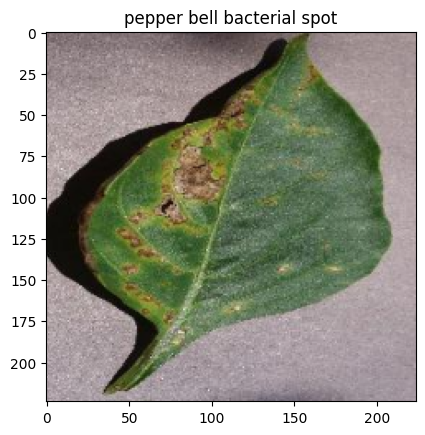

np.float32(85.68329)

In [ ]:
predict_disease(image_path='/content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG')

We are getting 85.7% of prediction is Pepper bell bacterial spot among all classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


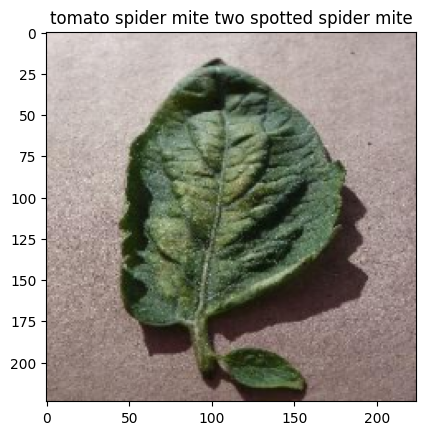

np.float32(77.562935)

In [ ]:
predict_disease(image_path='/content/plantvillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/002835d1-c18e-4471-aa6e-8d8c29585e9b___Com.G_SpM_FL 8584.JPG')

We are getting 77.5% of prediction is tomato spider mite two spotted spider mite among all classes.